<a href="https://colab.research.google.com/github/jasonhayes1987/MyProjects/blob/master/California_Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this post we are going to step through the process of building a regression model using the California Housing dataset derived from the 1990 U.S. census. The goal is to predict the median home value of a district as accurately as possible given around 20,000 data points across 8 features. 

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import t
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.datasets import fetch_california_housing

In [ ]:
cal_data = fetch_california_housing(as_frame=True)

In [ ]:
print(cal_data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In order to accurately predict a target, we have to identify the features that influence (change) it the most. That's the basis of a regression model, determining a dependent (target) variable using independent (feature) variables. If a feature influences the target, it means that the target value changes (increases/decreases) in some proportion to changes (increases/decreases)  in the feature value. This relationship can be viewed by plotting all the datapoints on a 2D (X-Y) plane, with X being the feature value and Y being the target value. Plotting the target (median house value) over each feature variable produces the following plots:

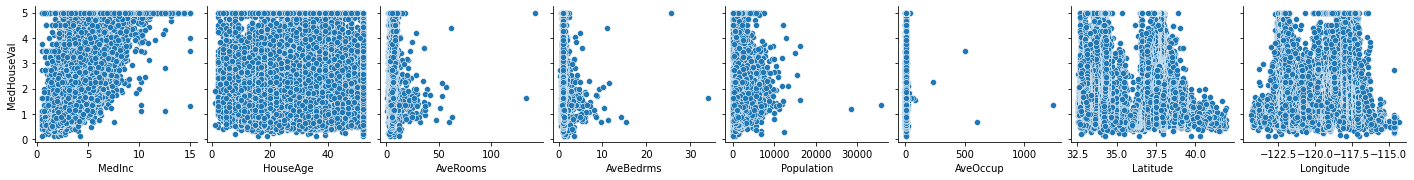

In [ ]:
sns.pairplot(cal_data['frame'], x_vars=cal_data['frame'].drop(columns='MedHouseVal').columns, y_vars='MedHouseVal')

If two variables are perfectly related, that means that as one changes, the other will change in exact proportion every time, forming a straight line when the datapoints are plotted (perfectly linear). As datapoints spread (move away from) the line, it means that the relationship between the two is becoming less linear (one doesn't change in direct proportion to the other). This spread is called the covariance and can be measured to determine how related two variables are. The relationship is measured by finding the average of the distance of each datapoint of each variable from their own averages multiplied together.

$Covariance(x,y)=\frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{n-1}$

*we subtract 1 from the number of samples because our data represents only a sample collected by the U.S.
Census Bureau of the total population datapoints*

Most of the plots above look to have high covariance, and no linear relationship with the target, with the exception of Median Income.

The code below calculates the covariance between each feature variable and the target


In [ ]:
# calculate covariance using means of each variable
def covariance(x, y):
    return np.sum(((x - x.mean())*(y - y.mean()))/(len(x)-1))

In [ ]:
covs = [covariance(cal_data['data'][f],cal_data['target']) for f in cal_data['data'].columns]
metrics = pd.DataFrame(index=cal_data['data'].columns)
metrics['covariance'] = covs
metrics

,covariance
MedInc,1.508475
HouseAge,1.533988
AveRooms,0.433826
AveBedrms,-0.025539
Population,-32.212487
AveOccup,-0.284494
Latitude,-0.355326
Longitude,-0.106274


*Discuss Correlation*

Data with high covariance means there is little relation between the variables. But what value is considered high? The issue with covariance is that it is not scale dependent, meaning the covariance between two variables can't be compared to the covariance between two other variables because the values are at 2 different scales. In order to put the values on the same scale so they can be easily compared, the values have to be divided by the product of the standard deviations of each variable. In mathematics, this relationship metric between variables is called correlation, and the strength of the relationship between them is the correlation coefficient or Pearson Correlation.

$
\begin{align}
Correlation(x,y) &= \frac{Covariance(x,y)}{\sigma_x \sigma_y} \\
Standard\hspace{1.6mm}Deviation=\sigma &= \frac{\sum_{i=1}^{n}(x_i - \bar{x})}{n-1}
\end{align}
$

The code below defines a correlation function that returns the correlation between input variables x and y by using the covariance and standard deviations of each. This data is then added to the the metrics dataframe and displayed for comparison.


In [ ]:
def correlation(x,y):
    cov = covariance(x,y)
    st_dev_x = standard_deviation(x)
    st_dev_y = standard_deviation(y)
    corr = cov / (st_dev_x * st_dev_y)
    return corr


def standard_deviation(x):
    return np.sqrt(sum(np.square(x-x.mean())) / (len(x)-1))

In [ ]:
corrs = [correlation(cal_data['data'][f],cal_data['target']) for f in cal_data['data'].columns]
metrics['correlation'] = corrs
metrics

,covariance,correlation
MedInc,1.508475,0.688075
HouseAge,1.533988,0.105623
AveRooms,0.433826,0.151948
AveBedrms,-0.025539,-0.046701
Population,-32.212487,-0.024650
AveOccup,-0.284494,-0.023737
Latitude,-0.355326,-0.144160
Longitude,-0.106274,-0.045967


Notice how the covariance between the Population and Median House Value is around -32 (highest across all feature variables) but the correlation is around -0.025 (almost the lowest across all feature variables). This demonstrates the need to use correlation to compare the relationship of each feature variable to the target because the covariance isn't scale dependent (each value is on a different scale).

The correlation between the median house value and median income is strongly positive(about 0.69) which is to be expected.  Typically, as your income increases, so does the value of the things you own. There is also some positive correlation between the age of the house and the number of rooms in the house with the median house value.  Again, that makes sense. The newer a house is, the higher in value it tends to be.  The more rooms a house has, the bigger it is and therefore the more valuable it tends to be. But how do we know this correlation isn't just by chance? It's possible that randomness is responsible for the correlation. Before moving forward, we need to determine that the correlation is not coincidental and therefore 'significant' and should be used in the regression model.



*Statistical Significance*

Statistical Significance is the method by which a metric is determined to not be coincidental. To be sure the correlation is not due to chance, the chance due to randomness would need to be very low. The chance due to randomness threshold commonly used is 5% (0.05), meaning we want to be 95% sure the correlation is significant (not by chance). In order to test if the correlation is significant, we test to see if it is not (this is called the null hypothesis). If the chance of no correlation falls below 5% (0.05), we can be 95% or more certain the correlation is not by chance. This is accomplished by mapping the correlation to a probability distribution (probability distribution = likelihood across all values that a variable could be equal to) to see if it falls outside 95% of the possibilities of occuring by chance (measured in standard deviations from no correlation). 

If the correlation is due to chance, that means there is no correlation between the two metrics and therefore the correlation coefficient is actually 0. What we are calculating is the probability that the actual correlation is 0 (null hypothesis)

$
\begin{align}
&H_{0}: r=0 \hspace{1.6mm}(no \hspace{1.6mm} correlation \hspace{1.6mm} exists)\hspace{1.6mm}(null\hspace{1.6mm}hypothesis) \\
&H_{1}: r \neq 0 \hspace{1.6mm}(correlation \hspace{1.6mm} exists)
\end{align}
$

Since we are testing for the probability the correlation is 0, the spectrum of values both above and below 0 have to be taken into account. This is called a 'two tail' test (one tail is testing the likelihood of a value being only above or below a threshold, not both above AND below). Being 95% certain the correlation is not due to chance is the same as being 5% certain that it is. Since we need to account for the probabilities both above and below 0, we need to split the 5% into two 2.5% probability ranges and place them at the end of both sides of the probability distribution. The probability at the low range (below 0) covers the 0%-2.5% range (2.5 percentile) and the high range covers the 97.5%-100% range (1 - 97.5 percentile). Its much easier to understand when visualized, so below is a t-distribution with 95% of the probabilites shaded, leaving 2.5% unshaded on each side of the distribution. If the probability ends up outside of the shaded area, we can be 5% (or less) certain the correlation is due to chance, which means we can be 95% (or more) certain the correlation is not due to chance.

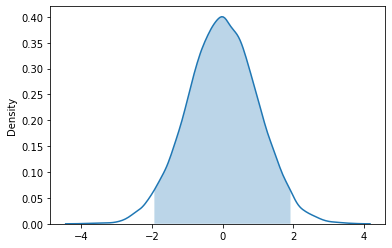

In [ ]:
# DONT INCLUDE IN ARTICLE
from scipy.stats import t
# create the t-distribution
t_dist = t.rvs(df=cal_data['target'].size - len(cal_data['data'].columns)-1, size=cal_data['target'].size)
# calculate points on distribution where probability is less than 2.5% and 97.5%
# to find middle 95% of probabilities (critical values) using the percent point
# function
cv_h = t(cal_data['target'].size - len(cal_data['data'].columns)-1).ppf(0.975)
cv_l = t(cal_data['target'].size - len(cal_data['data'].columns)-1).ppf(0.025)
# create the distribution plot
ax = sns.kdeplot(t_dist)
# grab distribution line
l1 = ax.lines[0]
# grab datapoints between -cv and cv values of x
xy = np.array([(x,y) for x,y in l1.get_xydata() if (x > cv_l) and (x < cv_h)])

# shade the region
ax.fill_between(xy[:,0], xy[:,1], alpha=0.3)
plt.show()

The values along the x-axis are called t-scores and as I mentioned above, represent estimated standard deviations from the null hypothesis (correlation = 0). 
The t-scores at the 2.5  and 97.5 percentile can be determined using the Percent Point Function. These t-scores are called the 'critical values'.

*I'm not going to go into the math behind calculating these values. They are important values to know and understand, but how they are derived is less important and would take an entire article in itself.*

The Percent Point Function (PPF) calculates a t-score from a percentile. Below, I use the PPF function for t-distributions from the scipy library to determine the critical values at the  2.5 and 97.5 percentile.

In [ ]:
# calculate points on distribution where probability is less than 2.5% and 97.5%
# to find middle 95% of probabilities (critical values) using the percent point
# function
cv_h = t(cal_data['target'].size - len(cal_data['data'].columns)-1).ppf(0.975)
cv_l = t(cal_data['target'].size - len(cal_data['data'].columns)-1).ppf(0.025)

# > critical values = -1.9600789769323244, 1.960078976932324

It makes sense that the critical values defining our lower and upper quantiles (2.5 and 97.5) would be opposites since the probability distribution is a symmetrical curve and the quantiles are symmetrically opposed. 

To determine where our correlation values fall on this distribution, we have to calculate their t-scores.
The t-score for correlation is calculated using the formula below: 

$\begin{align}
    t&=\frac{r}{\sqrt{\frac{1-r^2}{n-p}}} \\
    r &= correlation \\
    n &= num \hspace{1.6mm} samples \\
    p &= num \hspace{1.6mm} features \hspace{1.6mm}(including\hspace{1.6mm}bias)
\end{align}$

Let's run every correlation score between the feature variables and the target (median house value) to determine how sure we can be they are not due to chance.

In [ ]:
# map the correlations between each feature and the target to the distribution
# by calculating the correlations t-score
def t_score(r,n,p):
    return r * np.sqrt((n-p) / ((1-r**2)+1e-5))

t_scores = [t_score(r,cal_data['target'].size, len(cal_data['data'].columns)+1) for r in metrics['correlation'].values]
metrics['t-scores'] = t_scores
metrics

,covariance,correlation,t-scores
MedInc,1.508475,0.688075,136.198111
HouseAge,1.533988,0.105623,15.256479
AveRooms,0.433826,0.151948,22.081373
AveBedrms,-0.025539,-0.046701,-6.715119
Population,-32.212487,-0.024650,-3.541614
AveOccup,-0.284494,-0.023737,-3.410466
Latitude,-0.355326,-0.144160,-20.924923
Longitude,-0.106274,-0.045967,-6.609366


All of these values are outside the critical value range, some by a large margin. We can use the 'Cumulative Distribution Function' (CDF) to determine the percentile of the t-score and from that derive its p-value. If the t-score is greater than 0, we have to subtract the percentile from 1 in order to compute the p-value correctly (97.5 percentile leaves 2.5% of the right tail from 1). Since we are running a two tail test (accounting for probability ranges on both sides of a distribution), the value needs to be multiplied by 2 to for an accurate p-value.

Running the code below computes the p-value for each correlation.

In [ ]:
def p_value(t_score,n,f):
    if t_score > 0:
        return 1.0 - t(n-f).cdf(t_score)
    else:
        return t(n-f).cdf(t_score)

p_values = [p_value(t_score, cal_data['target'].size, len(cal_data['data'].columns)+1)*2 for t_score in t_scores]
metrics['p_value'] = p_values
metrics

,covariance,correlation,t-scores,p_value
MedInc,1.508475,0.688075,136.198111,0.000000e+00
HouseAge,1.533988,0.105623,15.256479,0.000000e+00
AveRooms,0.433826,0.151948,22.081373,0.000000e+00
AveBedrms,-0.025539,-0.046701,-6.715119,1.928018e-11
Population,-32.212487,-0.024650,-3.541614,3.985639e-04
AveOccup,-0.284494,-0.023737,-3.410466,6.497615e-04
Latitude,-0.355326,-0.144160,-20.924923,3.171577e-96
Longitude,-0.106274,-0.045967,-6.609366,3.954000e-11


The stronger the correlation between the feature and the target (positive or negative) the further from zero the t-score is and the more likely it will be outside the critical value range. The further outside the critical value range, the lower the p-value (probability correlation is equal to 0/due to chance). All of the correlations have a p-value far below 0.05 (5%), meaning the correlations are certainly not by chance.

*Discuss collinearity*

Now that we know all of our correlations are significant, we can trust these numbers and use them to determine which features we will use in the regression model.

Above we discussed how the median income, house age, and average rooms seem to be strongly correlated with the median house value. The only other feature that seems to have a strong correlation with the target is the latitude location of the block group, having a negative correlation of around -0.14. You might be asking yourself why the latitude shows a much stronger (triple) correlation than the longitude. While it's possible the latitude has a much stronger influence on the median house value than the longitude, it's not probable. 


Remember, regression is a measure of the influence independent variables (features) have on the dependent variable (target), meaning if the value of one independent variable (feature) is changed and all other independent variables (features) remain the same, how does that impact the dependent variable (target). In order for a variable to be independent, it can't be influenced by another variable. If a variable is influenced by another, that means that as one changes, so does the other and therefore a measure of its influence on the target can't be correctly calculated. The regression model may still find coefficients that appear to predict the target well, but they will not represent the true influence on the target and will make the model very sensitive to changes (like adding or removing feature variables). Just as we used correlation to determine the influence the feature variables had on the target, so can it be used to determine the influence on each other. Using whats called a correlation matrix, we can determine if two feature variables are related to (influence) each other and therefore not independent of each other. The Pandas library makes this very easy with the corr() method. All we have to do is pass our dataframe of all feature variables and target variable (cal_data['frame']) to the corr() function and display the results using a heatmap (using the Seaborn library).

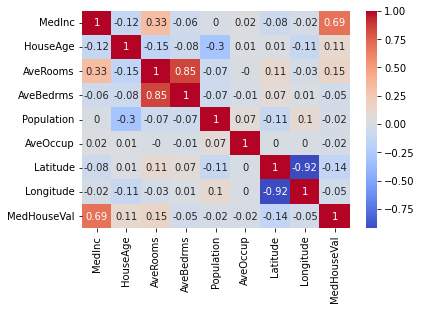

In [ ]:
corr = cal_data['frame'].corr(method='pearson')
sns.heatmap(data=corr.round(2), cmap='coolwarm', annot=True)

We can see the latitude and longitude variables are extremely negatively correlated (-.92), meaning as one increases, the other decreases at almost the same rate, making them dependent on one another. Average rooms and average bedrooms are also strongly positively correlated (.85), which makes sense. A larger house tends to have more bedrooms. This dependency (correlation) between feature variables is called collinearity and should ideally be attenuated as much as possible. It's important to understand that collinearity can't be eliminated completely from a regression model, as feature variables that are related (correlated) to the target will inevitably share some relation (correlation) to each other (for example, the age of homes in more affluent neighborhoods tends to be lower than those in lower income neighborhoods). 

Correlation between 2 feature variables is a good indication that collinearity exits, but what if a feature variable is correlated with the combination of 2 or more feature variables? This type of correlation is called multicollinearity and is unable to be identified by analyzing our correlation matrix above. There is, however, a metric we can use that can measure how much a variable is influenced by the other variables present in the regression called the Variance Inflation Factor (VIF). This is accomplished by running a regression with the feature variable set as the target (dependent variable) and using the remaining features as the independent variables. After completing the regression, we calculate the 'Coefficient of Determination' which measures how much of the variation of the target variable is predicted by the feature variables (how much of the target is explained by the features). From there, the VIF can be calculated and a determination can be made if multicollinearity exists.

Coefficient of Determination

There are a couple ways of calculating the Coefficient of Determination. One way is by squaring the correlation, which is why the Coefficient of Determination is often reffered to as 'r-squared' (r is used as the variable representing correlation). We have already calculated the correlation between all variables above. Squaring the values and plotting a heatmap of the results will highlight feature pairs where variations closely match (they explain each other well). 

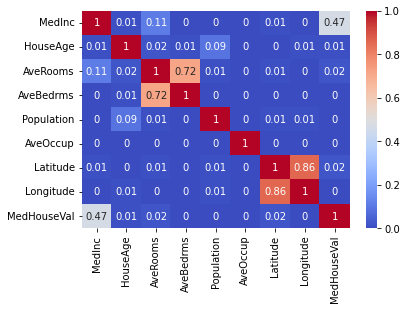

In [ ]:
coeff_det = corr**2
sns.heatmap(data=coeff_det.round(2), cmap='coolwarm', annot=True)

This doesn't really tell us anything new.  The correlation matrix highlighted the same data. If two features are correlated, the variability of one will closely match the other.

This only addresses collinearity (between 2 variables). If we want to look for the possibility of multicollinearity between a single variable and the rest, we have to try to predict the feature variable in question by using only the other feature variables (and a bias term). Thats exactly what a regression does. After the regression has converged, we measure for similarity between the true data (Y) and predictions by calculating the r-squared and VIF values. If a feature variable can be predicted by the others, that means much of the variation of the data in the feature variable is already present in (explained by) the variation of the others, and its r-squared value will be close to 1. The VIF divides 1 by whats not explained by the other feature variables (1-r-squared), which creates high values for feature variables where multicollinearity is present. Values greater than 10 are considered to be significant and the threshold at which many statisticians and data-science practitioners will remove the variable from the regression. We'll walk through several tests and compare data between them to determine which regression model/s suffer from the least amount of collinearity (all feature variables are mostly independent) and predicts the target most accurately (accounts for/explains most of the variability and has a low MSE).

The code below outlines the StandardScaler class we used in my previous post.  I added functions to run a regression and calculate the r-squared and VIF values, which are then used in the collinearity_test function that will take in a database of feature variables and return the r-squared and VIF values after a regression is run on each.

*The r-squared function below uses a different method by which to calculate the coefficient of determination.*

$r^2=1-\frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}$

In [ ]:
class StandardScaler():

    def __init__(self):
        self.mean = None
        self.standard_deviation = None

    def fit(self, data):
        self.mean = np.mean(data, axis=0)
        self.standard_deviation = np.sqrt(np.mean(np.square(data-self.mean), axis=0))

    def transform(self, data):
        return (data-self.mean)/self.standard_deviation

In [ ]:
def Regressor(X, Y, iterations, learning_rate):
    
    # set Theta
    Theta = np.random.randn(X.shape[1],1)

    mses = []
    for i in range(iterations):
        Yh = X.dot(Theta)
        residual = Y-Yh
        mse = np.sum((np.square(residual)))/len(Y)
        mses.append(mse)
        Theta -= (learning_rate/len(Yh))*(-2*X.T.dot(residual))

    return mses, Theta

In [ ]:
def r_squared(Y,predictions):
    # calculate residual sum of squares
    residuals = Y-predictions
    SSR = np.sum(residuals**2)
    # calculate total sum of squares
    SST=np.sum(np.square(Y-Y.mean()))
    # calculate coefficient of determination
    r_sq = 1 - (SSR / SST)
    
    return r_sq

In [ ]:
def VIF(r_sq):
    return 1/(1-r_sq)

In [ ]:
# run a regression on an all features to calculate coefficient of determination
# and value inflation factor

def collinearity_test(data, iterations, learning_rate):

    # create arrays to store R2 and VIF of each feature
    r2s = []
    VIFs = []

    for col in data.columns:
        # set X and Y data
        X = data.drop(columns=col).to_numpy()
        Y = data[col].to_numpy().reshape((-1,1))
        # scale X
        scaler = StandardScaler()
        scaler.fit(X)
        X = scaler.transform(X)
        # add column of ones to X
        X = np.column_stack((np.ones((X.shape[0],1)),X))

        _, Theta = Regressor(X, Y, iterations, learning_rate)
        
        # calculate r-squared
        r_sq = r_squared(Y,X.dot(Theta))
        r2s.append(r_sq)
        # calculate VIF
        vif = VIF(r_sq)
        VIFs.append(vif)

    return r2s, VIFs


Let's run the feature variables through the collinearity_test function and add the results to our metrics database

In [ ]:
r2s, VIFs = collinearity_test(cal_data['data'], 1000, 0.01)

# create dataframe to display VIF and R2 per feature
df = pd.DataFrame(index=cal_data['data'].columns)
# df['Feature']=cal_data['data'].columns
metrics['R2']=r2s
metrics['VIF'] = VIFs
metrics

,covariance,correlation,t-scores,p_value,R2,VIF
MedInc,1.508475,0.688075,136.198111,0.000000e+00,0.598405,2.490071
HouseAge,1.533988,0.105623,15.256479,0.000000e+00,0.187724,1.231109
AveRooms,0.433826,0.151948,22.081373,0.000000e+00,0.879211,8.278883
AveBedrms,-0.025539,-0.046701,-6.715119,1.927999e-11,0.856607,6.973829
Population,-32.212487,-0.024650,-3.541614,3.985636e-04,0.120663,1.137221
AveOccup,-0.284494,-0.023737,-3.410466,6.497611e-04,0.007665,1.007724
Latitude,-0.355326,-0.144160,-20.924923,3.168788e-96,0.891098,9.182531
Longitude,-0.106274,-0.045967,-6.609366,3.953963e-11,0.888368,8.958036


Median income is explained by almost 60% of the other variables, which is quite high. The VIF is low, so we'll keep it in there for now and see how it reacts to changes in the model.
Average rooms and average bedrooms probably account for much of the explanation in each other, especially since they were highly correlated (0.85). The VIFs are also a little on the high side. Since average rooms has both a higher r-squared and VIF than average bedrooms, let's remove average rooms from the dataset and see if it reduces the r-squared and VIF values of average bedrooms.
Latitude and longitute r-squared and VIF values are high as well, which confirms our suspision that they explain much of each other. Following the logic in the previous step, we'll remove latitude from the dataset and see how longitude reacts.

We have to establish a baseline first in order to have something to compare our changes to. The baseline we will use is a model that uses all feature variables to predict the target. Before running the data through the model, the data has to be split into training and testing datasets. In order to get an accurate prediction metric, predictions should be made using new data (data the model hasn't seen before) for which the true target is known. This keeps the model from becomming fitted so well to the data that it is unable to accurately predict new data (known as overfitting).

The method by which this is done is called Cross-Validation.  In a nutshell, Cross-Validation is performed by separating the data into 2 datasets, one used for training the model (training data), and one used for testing/validating the model (validation data).  Additionaly, we can split up the training data into a chosen number of equal parts called 'folds'. One fold is held as the test data, and the rest are fed to the regression as the training data. The regression iteration continues until each fold has been cycled as the test data. The MSE for the iteration is the average MSE over each test fold. This type of Cross-Validation is referred to as k-fold Cross-Validation and is considered the gold standard for alleviating overfitting and testing models. The k-fold Cross-Validation process is illustrated below for clarity.

*Insert Image of k-fold Cross Validation*
*http://karlrosaen.com/ml/learning-log/2016-06-20/k-fold-diagram.png*

In [ ]:
## code k-fold cross validation ##
def cross_validate(X, Y, iterations, learning_rate):

    #scale data
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)

    # add column of ones to X
    X = np.column_stack((np.ones((X.shape[0],1)),X))

    # initialize theta term
    theta = np.random.randn(X.shape[1],1)

    # split data into train and validation set
    ## shuffle data
    p = np.random.permutation(len(X))
    X = X[p]
    Y = Y[p]

    ## split
    test_percent = 10
    test_size = len(X) // test_percent

    x_train = X[:-test_size]
    y_train = Y[:-test_size]
    x_test = X[-test_size:]
    y_test = Y[-test_size:]

    # split train into k folds
    folds = 10
    fold_size = len(x_train) // folds

    # initialize array to store mses
    mses = []

    for i in range(iterations):
        # reset fold mses array to be empty
        fold_mses = []

        for k in range(folds):
            # get range of indices to use as test fold
            test_fold = np.arange(k*fold_size,(k+1)*fold_size)
            # set train and test data according to current test fold
            x_train_fold = np.delete(x_train, test_fold, axis=0)
            y_train_fold = np.delete(y_train, test_fold, axis=0)
            x_test_fold = np.take(x_train, test_fold, axis=0)
            y_test_fold = np.take(y_train, test_fold, axis=0)

            # run regression on training folds
            Yh = x_train_fold.dot(theta)
            residual = y_train_fold - Yh
            train_mse = np.sum((np.square(residual)))/len(y_train_fold)
            theta -= (learning_rate/len(Yh))*(-2*x_train_fold.T.dot(residual))

            # test on test fold
            Yh = x_test_fold.dot(theta)
            residual = y_test_fold - Yh
            test_mse = np.sum((np.square(residual)))/len(y_test_fold)

            fold_mses.append([train_mse, test_mse])

        mses.append(np.mean(fold_mses, axis=0))
        # if i % 10 == 0:
        #     print(f'Iteration {i}: {mses[-1]}')

    # test validation data to determine true MSE
    Yh = x_test.dot(theta)
    residual = y_test - Yh
    mse = np.sum((np.square(residual)))/len(y_test)
    # print(f'Final MSE on validation data: {mse}')

    return mse, mses, {'x_train':x_train, 'y_train':y_train, 'x_test':x_test, 'y_test':y_test, 'theta':theta}


Now we can establish a baseline metric by cross-validating a regression using every feature variable.

In [ ]:
mse, mses, data = cross_validate(cal_data['data'].to_numpy(), cal_data['target'].to_numpy().reshape((-1,1)), 1000, 0.01)

mse=0.5471310653792788
r-squared=0.5838323213704486


,covariance,correlation,t-scores,p_value,R2,VIF,coefficients
MedInc,1.508475,0.688075,136.198111,0.000000e+00,0.598405,2.490071,0.834469
HouseAge,1.533988,0.105623,15.256479,0.000000e+00,0.187724,1.231109,0.119183
AveRooms,0.433826,0.151948,22.081373,0.000000e+00,0.879211,8.278883,-0.273530
AveBedrms,-0.025539,-0.046701,-6.715119,1.927999e-11,0.856607,6.973829,0.296039
Population,-32.212487,-0.024650,-3.541614,3.985636e-04,0.120663,1.137221,-0.007482
AveOccup,-0.284494,-0.023737,-3.410466,6.497611e-04,0.007665,1.007724,-0.037284
Latitude,-0.355326,-0.144160,-20.924923,3.168788e-96,0.891098,9.182531,-0.887023
Longitude,-0.106274,-0.045967,-6.609366,3.953963e-11,0.888368,8.958036,-0.859589


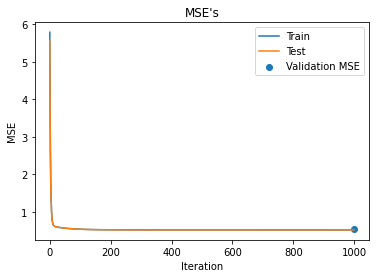

In [ ]:
# print metrics
print(f'mse={mse}')
rs = r_squared(data['y_test'], data['x_test'].dot(data['theta']))
print(f'r-squared={rs}')
mses = np.array(mses)
plt.plot(mses[:,0], label='Train')
plt.plot(mses[:,1], label='Test')
plt.scatter(x=1000, y=mse, label='Validation MSE')
plt.title("MSE's")
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.legend()
metrics['coefficients']=data['theta'][1:]
metrics

The mean squared error for both the train and test sets converge quickly. The convergence lines for both sets of data never separate, meaning the model isn't showing signs of overfitting to the training data. The true test of accuracy is on the validation data the model has yet to see. The MSE of the validation set lines up perfectly with the MSE's of both the train and test sets at the end of model training (iteration 1000), proving the model can predict accurately on data it has never seen before. The r-squared value shows the model is able to explain 58.3% of the variability of the median home value metric. Let's see how these metrics change and if we can improve any if we modify the regression model.

Before continuing, I'll modify the code to encapsulate the entire process up until now in a function I'll name 'evaluate'. 

In [ ]:
## code a function that will take in X and Y data and return a dictionary of metrics
def evaluate(X,Y, iterations, learning_rate):
    
    # calculate covariance between each feature and the target
    covs = [covariance(X[f],Y) for f in X.columns]
    # calculate correlation between each feature and the target
    corrs = [correlation(X[f],Y) for f in X.columns]
    # calculate t-scores of each feature
    t_scores = [t_score(r,X.shape[0], X.shape[1]) for r in corrs]
    # calculate p-value of each feature
    p_values = [p_value(t_score, X.shape[0], X.shape[1])*2 for t_score in t_scores]
    # run collinearity test on features to get r-squared and value inflation
    r2s, VIFs = collinearity_test(X, iterations)
    # run cross validation of regression model 
    val_mse, mses, data = cross_validate(X.to_numpy(), Y.to_numpy().reshape((-1,1)), iterations, learning_rate)
    # calculate r-squared of the target
    rs = r_squared(data['y_test'], data['x_test'].dot(data['theta']))
    # build database of metrics
    metrics = pd.DataFrame(index=X.columns)
    metrics['covariance'] = covs
    metrics['correlation'] = corrs
    metrics['t-score'] = t_scores
    metrics['p-value'] = p_values
    metrics['r-squared'] = r2s
    metrics['VIF'] = VIFs
    metrics['coefficients']=data['theta'][1:]

    # return dictionary of metrics
    return {'validation MSE': val_mse,
            'MSEs': mses,
            'r-squared': rs,
            'metrics': metrics,
            'training data': data}


Now we'll run a regression on a dataset that doesn't include the average rooms and latitude feature variables to see how that effects the model

In [ ]:
data = evaluate(cal_data['data'].drop(columns=['AveRooms','Latitude']), cal_data['target'], 1000, 0.01)

In [ ]:
print(data['validation MSE'])
print(data['r-squared'])

0.5928063257288153
0.511122753967993


In [ ]:
data['metrics']

,covariance,correlation,t-score,p-value,r-squared,VIF,coefficients
MedInc,1.508475,0.688075,136.208013,0.000000e+00,0.021943,1.022435,0.821893
HouseAge,1.533988,0.105623,15.257588,0.000000e+00,0.120130,1.136532,0.232663
AveBedrms,-0.025539,-0.046701,-6.715607,1.921568e-11,0.020482,1.020911,0.029981
Population,-32.212487,-0.024650,-3.541871,3.981750e-04,0.107159,1.120021,0.045060
AveOccup,-0.284494,-0.023737,-3.410714,6.491708e-04,0.006683,1.006728,-0.046913
Longitude,-0.106274,-0.045967,-6.609846,3.941177e-11,0.017505,1.017817,-0.020790


The MSE increased a small amount and there's essentially no collinearity occuring but at the cost of about 7% of the targets explainabiliity (r-squared). The r-squared value of Median Income dropped to 2% from 60%, meaning much of its variability was contained in the Average Rooms feature. This makes sense. Neighborhoods with higher median incomes tend to have bigger houses, and bigger houses have more rooms.
How about swapping out average bedrooms for average rooms.  Perhaps it contains some variability in the target that was lost when removing it.

In [ ]:
data = evaluate(cal_data['data'].drop(columns=['AveBedrms', 'Latitude']), cal_data['target'], 1000, 0.01)

In [ ]:
print(data['validation MSE'])
print(data['r-squared'])

0.6348141560950129
0.5205750454284308


In [ ]:
data['metrics']

,covariance,correlation,t-score,p-value,r-squared,VIF,coefficients
MedInc,1.508475,0.688075,136.208013,0.000000e+00,0.112423,1.126662,0.839058
HouseAge,1.533988,0.105623,15.257588,0.000000e+00,0.130632,1.150261,0.221889
AveRooms,0.433826,0.151948,22.082978,0.000000e+00,0.133714,1.154354,-0.063160
Population,-32.212487,-0.024650,-3.541871,3.981750e-04,0.111276,1.125209,0.032400
AveOccup,-0.284494,-0.023737,-3.410714,6.491708e-04,0.006669,1.006713,-0.046611
Longitude,-0.106274,-0.045967,-6.609846,3.941177e-11,0.018277,1.018617,-0.021463


We basically get the same result. The r-squared value of median income increased to 11%, which tells us that more of its information (variability) is present in the average rooms feature, which seems logical (A higher median income neighborhood doesn't necessarily mean the houses will have more bedrooms, but will most likely have more rooms in total).
Whats the takeaway? Reducing the collinearity of a model so the feature variable coefficients represent closely their actual weight (influence) may, and often does, reduce the models ability to explain (account for the variability of) the target. If the purpose of the model is to predict the target as accurately as possible, you may elect to keep all the feature variables to capture the most variability of the target. If you want to know what the fundemental driving forces are and by how much they influence the target, reducing the collinearity of the model to find those fundemental features would be more important than achieving the highest accuracy.